### Import lib

In [1]:
import os
os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from treeconfigparser import TreeConfigParser

import models.reg as rg 
from data.Data import Data

### Case choices

In [54]:
# reg_par, reg_pw, reg_ber
dataset = "reg_pw"
weights = "reg_pw"

### Data download

In [55]:
config_file = os.path.join("nb/sim/cfg", dataset + ".cfg")
config = TreeConfigParser()
config.readfiles(config_file)
data = Data(config)
data.prepareXCO2Data()
data.superpose_field_in_three_channels()

x_train.shape[0] (13748, 160, 160, 1)
y_train.shape (13748, 1)


### Load model

In [56]:
model = keras.models.load_model(os.path.join("nb/sim/weights", weights + ".h5"), compile=True)

## Evaluation

In [57]:
x_valid = tf.convert_to_tensor(data.x_valid[0], np.float32)
pred_valid = tf.convert_to_tensor(model.predict(x_valid), np.float32)
y_valid = tf.convert_to_tensor(data.y_valid, np.float32)

In [58]:
loss_valid = model.evaluate(x=x_valid, y=y_valid, batch_size=64)

54/54 [==============================] - 3s 42ms/step - loss: 0.0634


#### Baseline

In [43]:
mean_valid = tf.math.reduce_mean(y_valid) * tf.ones_like(y_valid, np.float32)
print("mean_valid", mean_valid[0].numpy())
print("mean everywhere baseline:", model.compute_loss(y=y_valid, y_pred=mean_valid).numpy())

mean_valid [16.735853]
mean everywhere baseline: 0.18245076


### Random output

In [34]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

0.023941694
truth: 22.47888946533203
pred: 26.40794


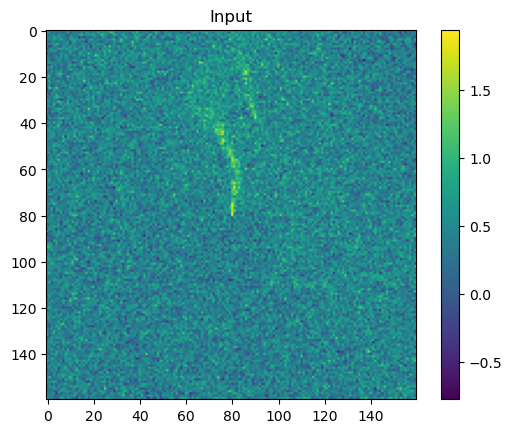

In [41]:
idx = int(np.random.uniform(0,data.y_valid.shape[0]*0.2))
print(model.compute_loss(y=y_valid[idx:idx+1], y_pred=pred_valid[idx:idx+1]).numpy())

print("truth:", np.squeeze(data.y_valid[idx]))
print("pred:", np.squeeze(model(tf.expand_dims(data.x_valid[0][idx], 0))[0]))
plt.figure()
plt.imshow(np.squeeze(data.x_valid[0][idx,:,:,0]))
plt.colorbar()
plt.title("Input")
plt.savefig("nb/sim/fig/reg-input.png")

### Worst evaluation

tf.Tensor(0.00056015403, shape=(), dtype=float32)
truth: 16.906509399414062
pred: 16.487684


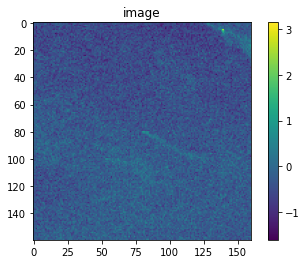

In [16]:
idx_worst = np.argmax(loss_valid)
print(model.compute_loss(y=y_valid[idx_worst:idx_worst+1], y_pred=pred_valid[idx_worst:idx_worst+1]))

print("truth:", np.squeeze(data.y_valid[idx_worst]))
print("pred:", np.squeeze(model(tf.expand_dims(data.x_valid[0][idx_worst], 0))[0]))
plt.figure()
plt.imshow(np.squeeze(data.x_valid[0][idx_worst,:,:,0]))
plt.colorbar()
plt.title("Input")

### Best evaluation

tf.Tensor(0.00056015403, shape=(), dtype=float32)
truth: 16.906509399414062
pred: 16.487684


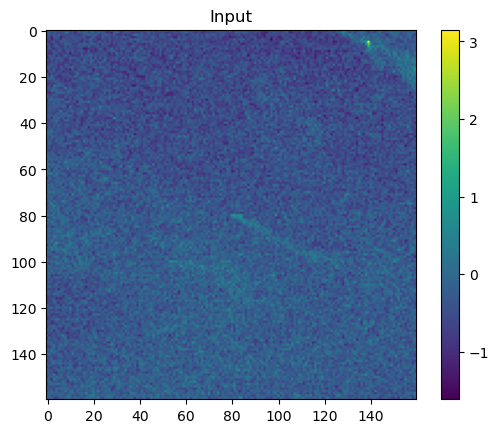

In [33]:
idx_best = np.argmin(loss_valid)
print(model.compute_loss(y=y_valid[idx_best:idx_best+1], y_pred=pred_valid[idx_best:idx_best+1]))

print("truth:", np.squeeze(data.y_valid[idx_best]))
print("pred:", np.squeeze(model(tf.expand_dims(data.x_valid[0][idx_best], 0))[0]))
plt.figure()
plt.imshow(np.squeeze(data.x_valid[0][idx_best,:,:,0]))
plt.colorbar()
plt.title("Input")

### Histogram perf.

In [26]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
font = {'size'   : 20}
plt.rc('font', **font)

'\nplt.figure(figsize=(15,8))\nsns.histplot(\n    data=df,\n    x="pred/truth",\n    hue="y_true_bin",\n    log_scale=False,\n    element="step",\n    cumulative=True,\n    stat="density",\n    common_norm=False,\n    bins=50,\n)\n'

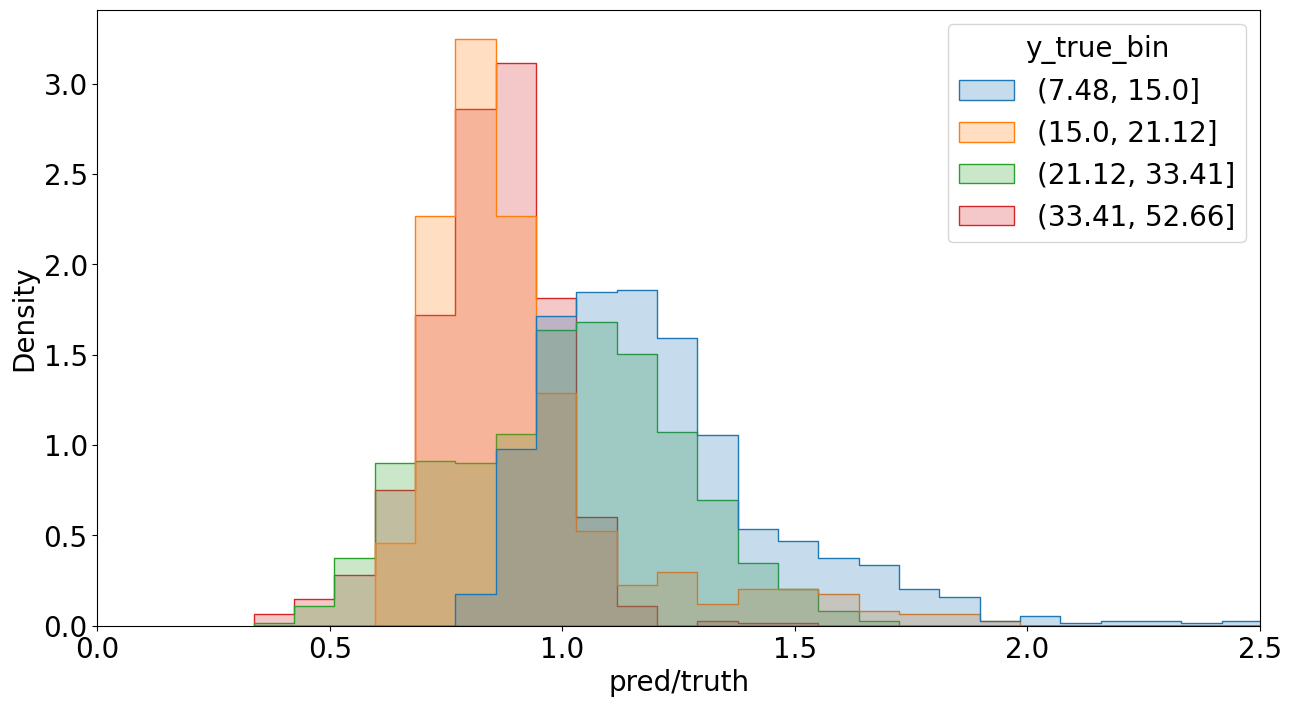

In [28]:
df = pd.DataFrame({'y_true': np.squeeze(data.y_valid), 'y_pred': np.squeeze(pred_valid.numpy()), 
                   'pred/truth': np.squeeze(pred_valid.numpy())/np.squeeze(data.y_valid)})
df["y_true_bin"] = pd.qcut(df["y_true"], q=4, precision=2)
plt.figure(figsize=(15,8))
sns.histplot(
    data=df,
    x="pred/truth",
    hue="y_true_bin",
    log_scale=False,
    element="step",
    #cumulative=True,
    stat="density",
    common_norm=False,
    bins=200,
)
plt.xlim(0,2.5)
plt.savefig(os.path.join("nb/sim/fig",dataset + "_hist_pred_truth.png"), transparent=True)
"""
plt.figure(figsize=(15,8))
sns.histplot(
    data=df,
    x="pred/truth",
    hue="y_true_bin",
    log_scale=False,
    element="step",
    cumulative=True,
    stat="density",
    common_norm=False,
    bins=50,
)
"""